# Tutorial 2 - RNN Time Series

In this notebook, we will predict the Stock Price: COSTCO. 

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import mean_squared_error


# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(142)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Read the Dataset

In [2]:
import pandas as pd

import yfinance as yf

# Define the ticker symbol for Costco 
ticker = "COST"

# Get the stock data from Yahoo Finance for the past 300 days
data = yf.download(ticker, period="300d", interval="1d")

# Extract the closing prices for the past 9 days
stock_price = data["Close"][-300:]

[*********************100%***********************]  1 of 1 completed


In [3]:
# Convert the Series to a DataFrame with headers
df = pd.DataFrame({'Date': stock_price.index, 'ClosePrice': stock_price.values})

df.head()

,Date,ClosePrice
0,2022-02-10,518.479980
1,2022-02-11,509.670013
2,2022-02-14,506.559998
3,2022-02-15,513.919983
4,2022-02-16,512.400024


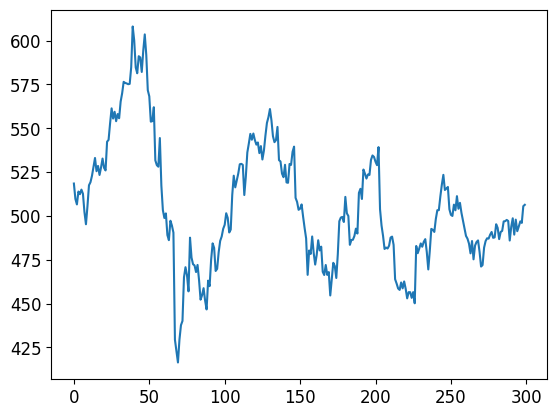

In [4]:
#Plot Stock Closing Price

plt.plot(df['ClosePrice'])
plt.show()

# Data Cleanup

## RESHAPE the data set!

In [5]:
df.shape

(300, 2)

In [6]:
# we will reshape by 10

df.shape[0]/10

30.0

In [7]:
df.groupby(['Date']).count()

,ClosePrice
Date,
2022-02-10,1
2022-02-11,1
2022-02-14,1
2022-02-15,1
2022-02-16,1
...,...
2023-04-17,1
2023-04-18,1
2023-04-19,1


In [8]:
# Find the reading count for each day

df_count = pd.DataFrame(df.groupby(['Date']).count()['ClosePrice'])

df_count

,ClosePrice
Date,
2022-02-10,1
2022-02-11,1
2022-02-14,1
2022-02-15,1
2022-02-16,1
...,...
2023-04-17,1
2023-04-18,1
2023-04-19,1


In [9]:
# Re-organize the data set by day 
temp = np.array(df['ClosePrice']).reshape(30,10)

temp

array([[518.47998047, 509.67001343, 506.55999756, 513.91998291,
        512.40002441, 515.01000977, 512.66998291, 502.17999268,
        495.26000977, 505.57998657],
       [517.48999023, 519.25      , 522.92999268, 528.        ,
        533.04998779, 525.5       , 528.52001953, 523.35998535,
        527.65002441, 532.7199707 ],
       [527.41998291, 525.95001221, 542.32000732, 543.39001465,
        552.78997803, 561.34997559, 555.5300293 , 559.41998291,
        554.02001953, 558.10998535],
       [555.71002197, 565.21002197, 569.97998047, 576.4699707 ,
        575.84997559, 575.57000732, 575.13000488, 575.32000732,
        584.78997803, 608.04998779],
       [600.03997803, 584.66998291, 581.35998535, 591.09002686,
        590.39001465, 582.11999512, 594.29998779, 603.5300293 ,
        591.73999023, 571.70001221],
       [568.21002197, 553.76000977, 554.08001709, 562.        ,
        531.7199707 , 528.95001221, 528.08001709, 544.42999268,
        517.32000732, 503.35998535],
       [49

In [10]:
# Convert to dataframe

conv_df = pd.DataFrame(temp, columns=np.arange(0,10,1))

conv_df

,0,1,2,3,4,5,6,7,8,9
0,518.479980,509.670013,506.559998,513.919983,512.400024,515.010010,512.669983,502.179993,495.260010,505.579987
1,517.489990,519.250000,522.929993,528.000000,533.049988,525.500000,528.520020,523.359985,527.650024,532.719971
2,527.419983,525.950012,542.320007,543.390015,552.789978,561.349976,555.530029,559.419983,554.020020,558.109985
3,555.710022,565.210022,569.979980,576.469971,575.849976,575.570007,575.130005,575.320007,584.789978,608.049988
4,600.039978,584.669983,581.359985,591.090027,590.390015,582.119995,594.299988,603.530029,591.739990,571.700012
5,568.210022,553.760010,554.080017,562.000000,531.719971,528.950012,528.080017,544.429993,517.320007,503.359985
6,498.829987,501.459991,489.079987,486.179993,497.269989,494.529999,490.470001,429.399994,422.929993,416.429993
7,429.480011,437.709991,440.109985,464.989990,470.760010,466.220001,456.989990,487.609985,476.250000,472.470001
8,471.779999,467.989990,472.049988,463.309998,452.250000,454.799988,458.790009,451.760010,446.690002,463.109985
9,459.959991,475.000000,484.369995,481.750000,468.609985,469.839996,479.279999,485.760010,488.260010,492.649994


# Reshape for Standardizing Data

In [11]:
# Let's create a single sequence (i.e., feature) for standardization

std_df = np.array(conv_df).ravel().reshape(-1,1)

std_df.shape

(300, 1)

In [12]:
std_df

array([[518.47998047],
       [509.67001343],
       [506.55999756],
       [513.91998291],
       [512.40002441],
       [515.01000977],
       [512.66998291],
       [502.17999268],
       [495.26000977],
       [505.57998657],
       [517.48999023],
       [519.25      ],
       [522.92999268],
       [528.        ],
       [533.04998779],
       [525.5       ],
       [528.52001953],
       [523.35998535],
       [527.65002441],
       [532.7199707 ],
       [527.41998291],
       [525.95001221],
       [542.32000732],
       [543.39001465],
       [552.78997803],
       [561.34997559],
       [555.5300293 ],
       [559.41998291],
       [554.02001953],
       [558.10998535],
       [555.71002197],
       [565.21002197],
       [569.97998047],
       [576.4699707 ],
       [575.84997559],
       [575.57000732],
       [575.13000488],
       [575.32000732],
       [584.78997803],
       [608.04998779],
       [600.03997803],
       [584.66998291],
       [581.35998535],
       [591

## Standardize the values

In [13]:
# Next, standardize

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

std_stock = scaler.fit_transform(std_df)

## Reshape the data back 

In [14]:
stock_reshaped = std_stock.reshape(30,10)

stock_reshaped.shape

(30, 10)

In [15]:
#Pandas version of the reshaped data

pd.DataFrame(stock_reshaped, columns=np.arange(0,10,1))

,0,1,2,3,4,5,6,7,8,9
0,0.379104,0.127830,0.039128,0.249046,0.205694,0.280135,0.213394,-0.085797,-0.283165,0.011176
1,0.350868,0.401066,0.506025,0.650629,0.794662,0.579325,0.665461,0.518289,0.640647,0.785250
2,0.634086,0.592160,1.059057,1.089575,1.357676,1.601821,1.435827,1.546774,1.392759,1.509411
3,1.440961,1.711915,1.847961,2.033066,2.015382,2.007397,1.994848,2.000267,2.270365,2.933775
4,2.705318,2.266942,2.172536,2.450052,2.430086,2.194213,2.541605,2.804859,2.468590,1.897019
5,1.797479,1.385343,1.394470,1.620360,0.756728,0.677725,0.652911,1.119237,0.346019,-0.052142
6,-0.181344,-0.106332,-0.459429,-0.542141,-0.225837,-0.303986,-0.419783,-2.161592,-2.346126,-2.531516
7,-2.159310,-1.924578,-1.856127,-1.146512,-0.981942,-1.111430,-1.374684,-0.501355,-0.825359,-0.933170
8,-0.952850,-1.060947,-0.945150,-1.194428,-1.509875,-1.437146,-1.323345,-1.523851,-1.668455,-1.200132
9,-1.289975,-0.861011,-0.593765,-0.668491,-1.043264,-1.008182,-0.738939,-0.554119,-0.482816,-0.357607


# Split the Data

**In certain cases, we cannot use a random split. For example, if we are trying to predict the stock market, we cannot use a random split. We need to use a chronological split.**

BUT, keep in mind if we have something like hourly readings of dayly temperature, we can use a random split on days, but the sequence of the temperature within the day is important to remain sequential.

In this case, we are not using random split because we are using stock market data.

In [16]:
from sklearn.model_selection import train_test_split


# if we neede to maintain the ordering of the data, we can use the following code to split the data
split_point = int(len(stock_reshaped)*0.7)
train, test = stock_reshaped[:split_point], stock_reshaped[split_point:]

In [17]:
train.shape

(21, 10)

In [18]:
train[:2]

array([[ 0.37910356,  0.12783   ,  0.03912766,  0.24904555,  0.20569404,
         0.28013476,  0.21339366, -0.08579669, -0.28316505,  0.01117626],
       [ 0.35086754,  0.40106568,  0.50602462,  0.65062889,  0.79466216,
         0.57932511,  0.66546063,  0.51828867,  0.64064705,  0.78524958]])

In [19]:
test.shape

(9, 10)

In [20]:
test[:2]

array([[-0.49935858, -0.48452684, -0.61800816, -1.17731455, -1.24747721,
        -1.32790808, -1.35101043, -1.23007951, -1.32562674, -1.21325193],
       [-1.33161602, -1.48876981, -1.38780342, -1.38865903, -1.48049833,
        -1.38694781, -1.56862969, -0.63654697, -0.75405545, -0.67847362]])

# Create Input and Target values

The first 9 days will be input to predict the 10th reading (i.e., target)

In [21]:
# The first 9 columns are inputs

train_inputs = train[:,:9]


pd.DataFrame(train_inputs, columns=np.arange(0,9,1))

,0,1,2,3,4,5,6,7,8
0,0.379104,0.127830,0.039128,0.249046,0.205694,0.280135,0.213394,-0.085797,-0.283165
1,0.350868,0.401066,0.506025,0.650629,0.794662,0.579325,0.665461,0.518289,0.640647
2,0.634086,0.592160,1.059057,1.089575,1.357676,1.601821,1.435827,1.546774,1.392759
3,1.440961,1.711915,1.847961,2.033066,2.015382,2.007397,1.994848,2.000267,2.270365
4,2.705318,2.266942,2.172536,2.450052,2.430086,2.194213,2.541605,2.804859,2.468590
5,1.797479,1.385343,1.394470,1.620360,0.756728,0.677725,0.652911,1.119237,0.346019
6,-0.181344,-0.106332,-0.459429,-0.542141,-0.225837,-0.303986,-0.419783,-2.161592,-2.346126
7,-2.159310,-1.924578,-1.856127,-1.146512,-0.981942,-1.111430,-1.374684,-0.501355,-0.825359
8,-0.952850,-1.060947,-0.945150,-1.194428,-1.509875,-1.437146,-1.323345,-1.523851,-1.668455
9,-1.289975,-0.861011,-0.593765,-0.668491,-1.043264,-1.008182,-0.738939,-0.554119,-0.482816


## Add one more dimension to make it ready for RNNs

See here for more details: https://keras.io/layers/recurrent/, and https://shiva-verma.medium.com/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e


In [22]:
train_inputs

array([[ 0.37910356,  0.12783   ,  0.03912766,  0.24904555,  0.20569404,
         0.28013476,  0.21339366, -0.08579669, -0.28316505],
       [ 0.35086754,  0.40106568,  0.50602462,  0.65062889,  0.79466216,
         0.57932511,  0.66546063,  0.51828867,  0.64064705],
       [ 0.63408592,  0.59216014,  1.05905711,  1.08957533,  1.35767648,
         1.60182053,  1.43582688,  1.54677422,  1.39275912],
       [ 1.44096054,  1.71191488,  1.84796129,  2.03306561,  2.01538241,
         2.0073973 ,  1.99484776,  2.00026692,  2.27036478],
       [ 2.7053178 ,  2.26694234,  2.17253621,  2.45005168,  2.43008627,
         2.19421283,  2.54160461,  2.80485933,  2.46858962],
       [ 1.79747941,  1.38534325,  1.39447034,  1.62036021,  0.75672807,
         0.67772467,  0.65291109,  1.11923708,  0.34601938],
       [-0.18134393, -0.10633222, -0.45942864, -0.54214084, -0.22583741,
        -0.30398607, -0.41978333, -2.16159211, -2.34612631],
       [-2.1593099 , -1.92457844, -1.85612699, -1.1465117 , -0

In [23]:
train_inputs.shape 

(21, 9)

In [24]:
#Create an additional dimension for train

train_x = train_inputs[:,:,np.newaxis]

train_x.shape 

(21, 9, 1)

In [25]:
train_x

array([[[ 0.37910356],
        [ 0.12783   ],
        [ 0.03912766],
        [ 0.24904555],
        [ 0.20569404],
        [ 0.28013476],
        [ 0.21339366],
        [-0.08579669],
        [-0.28316505]],

       [[ 0.35086754],
        [ 0.40106568],
        [ 0.50602462],
        [ 0.65062889],
        [ 0.79466216],
        [ 0.57932511],
        [ 0.66546063],
        [ 0.51828867],
        [ 0.64064705]],

       [[ 0.63408592],
        [ 0.59216014],
        [ 1.05905711],
        [ 1.08957533],
        [ 1.35767648],
        [ 1.60182053],
        [ 1.43582688],
        [ 1.54677422],
        [ 1.39275912]],

       [[ 1.44096054],
        [ 1.71191488],
        [ 1.84796129],
        [ 2.03306561],
        [ 2.01538241],
        [ 2.0073973 ],
        [ 1.99484776],
        [ 2.00026692],
        [ 2.27036478]],

       [[ 2.7053178 ],
        [ 2.26694234],
        [ 2.17253621],
        [ 2.45005168],
        [ 2.43008627],
        [ 2.19421283],
        [ 2.54160461],
   

## Set the target

In [26]:
# The last column (9) is TARGET

train_target = train[:,-1]


pd.DataFrame(train_target, columns=['9'])

,9
0,0.011176
1,0.785250
2,1.509411
3,2.933775
4,1.897019
5,-0.052142
6,-2.531516
7,-0.933170
8,-1.200132
9,-0.357607


## Repeat for TEST

In [27]:
test.shape

(9, 10)

In [28]:
# The first 9 columns (from 0 to 9) are inputs

test_inputs = test[:,:9]

In [29]:
#Create an additional dimension for test

test_x = test_inputs[:,:,np.newaxis]

test_x.shape 

(9, 9, 1)

In [30]:
# The last column (9) is TARGET

test_target = test[:,-1]


pd.DataFrame(test_target, columns=['9'])

,9
0,-1.213252
1,-0.678474
2,-0.408089
3,-0.039306
4,-0.343631
5,-0.732094
6,-0.497076
7,-0.547845
8,0.033138


In [31]:
performance = pd.DataFrame({"model": [], "RMSE": []})

## Simple RNN with more layers

In [32]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [33]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 3s 3s/step - loss: 1.4518
Epoch 2/30
1/1 [==============================] - 0s 12ms/step - loss: 1.3103
Epoch 3/30
1/1 [==============================] - 0s 19ms/step - loss: 1.1796
Epoch 4/30
1/1 [==============================] - 0s 10ms/step - loss: 1.0559
Epoch 5/30
1/1 [==============================] - 0s 14ms/step - loss: 0.9369
Epoch 6/30
1/1 [==============================] - 0s 14ms/step - loss: 0.8256
Epoch 7/30
1/1 [==============================] - 0s 11ms/step - loss: 0.7216
Epoch 8/30
1/1 [==============================] - 0s 11ms/step - loss: 0.6276
Epoch 9/30
1/1 [==============================] - 0s 14ms/step - loss: 0.5462
Epoch 10/30
1/1 [==============================] - 0s 12ms/step - loss: 0.4794
Epoch 11/30
1/1 [==============================] - 0s 11ms/step - loss: 0.4289
Epoch 12/30
1/1 [==============================] - 0s 15ms/step - loss: 0.3933
Epoch 13/30
1/1 [==============================] - 0s 11ms/step

### Predictions

In [34]:
#Predict:
y_pred = model.predict(test_x)


1/1 [==============================] - 0s 413ms/step


In [35]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [36]:
comparison

,actual,predicted
0,462.649994,462.452179
1,481.399994,469.095276
2,490.880005,486.096344
3,503.809998,517.516296
4,493.140015,502.297180
5,479.519989,483.519836
6,487.760010,488.020020
7,485.980011,495.923981
8,506.350006,498.329285


In [37]:
rmse = mean_squared_error(comparison['actual'], comparison['predicted'])

In [38]:
performance = pd.concat([performance, pd.DataFrame({'model':"Simple RNN", 
                                                    'RMSE': [rmse]}, index=[0])])

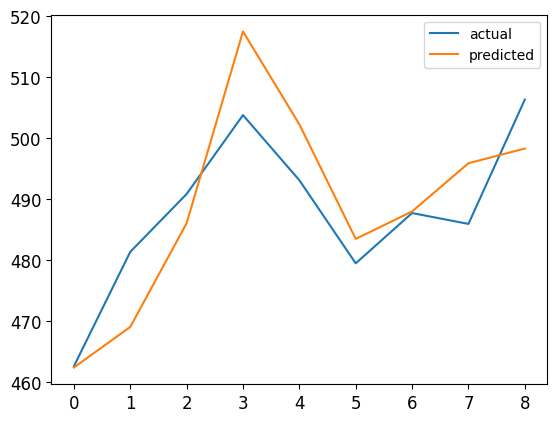

In [39]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# LSTM with more layers

In [40]:
model = keras.models.Sequential([
    keras.layers.LSTM(32, activation='tanh', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='tanh', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 5s 5s/step - loss: 1.4639
Epoch 2/30
1/1 [==============================] - 0s 10ms/step - loss: 1.4130
Epoch 3/30
1/1 [==============================] - 0s 11ms/step - loss: 1.3641
Epoch 4/30
1/1 [==============================] - 0s 10ms/step - loss: 1.3167
Epoch 5/30
1/1 [==============================] - 0s 9ms/step - loss: 1.2705
Epoch 6/30
1/1 [==============================] - 0s 11ms/step - loss: 1.2249
Epoch 7/30
1/1 [==============================] - 0s 10ms/step - loss: 1.1798
Epoch 8/30
1/1 [==============================] - 0s 11ms/step - loss: 1.1348
Epoch 9/30
1/1 [==============================] - 0s 11ms/step - loss: 1.0899
Epoch 10/30
1/1 [==============================] - 0s 10ms/step - loss: 1.0449
Epoch 11/30
1/1 [==============================] - 0s 10ms/step - loss: 0.9999
Epoch 12/30
1/1 [==============================] - 0s 10ms/step - loss: 0.9549
Epoch 13/30
1/1 [==============================] - 0s 11ms/step 

### Predictions

In [42]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 1s 955ms/step


In [43]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [44]:
rmse = mean_squared_error(comparison['actual'], comparison['predicted'])

In [45]:
performance = pd.concat([performance, pd.DataFrame({'model':"LSTM", 
                                                    'RMSE': [rmse]}, index=[0])])

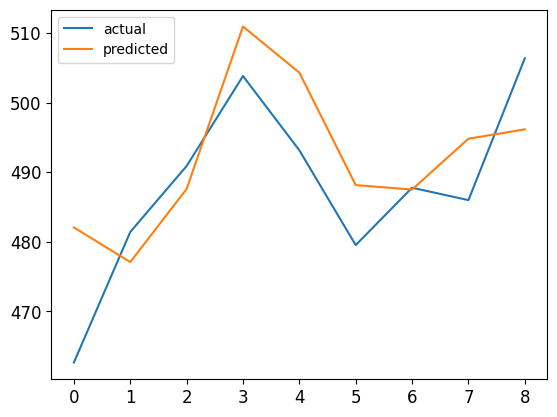

In [46]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# GRU (with more layers)

In [47]:
model = keras.models.Sequential([
    keras.layers.GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [48]:
np.random.seed(142)
tf.random.set_seed(142)

model.compile(loss="mse", optimizer='RMSprop')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 1.5776
Epoch 2/30
1/1 [==============================] - 0s 23ms/step - loss: 1.4265
Epoch 3/30
1/1 [==============================] - 0s 34ms/step - loss: 1.3206
Epoch 4/30
1/1 [==============================] - 0s 16ms/step - loss: 1.2331
Epoch 5/30
1/1 [==============================] - 0s 22ms/step - loss: 1.1551
Epoch 6/30
1/1 [==============================] - 0s 16ms/step - loss: 1.0839
Epoch 7/30
1/1 [==============================] - 0s 15ms/step - loss: 1.0173
Epoch 8/30
1/1 [==============================] - 0s 16ms/step - loss: 0.9536
Epoch 9/30
1/1 [==============================] - 0s 19ms/step - loss: 0.8929
Epoch 10/30
1/1 [==============================] - 0s 15ms/step - loss: 0.8348
Epoch 11/30
1/1 [==============================] - 0s 15ms/step - loss: 0.7795
Epoch 12/30
1/1 [==============================] - 0s 14ms/step - loss: 0.7277
Epoch 13/30
1/1 [==============================] - 0s 23ms/step

### Predictions

In [49]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 410ms/step


In [50]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [51]:
rmse = mean_squared_error(comparison['actual'], comparison['predicted'])

In [52]:
performance = pd.concat([performance, pd.DataFrame({'model':"GRU", 
                                                    'RMSE': [rmse]}, index=[0])])

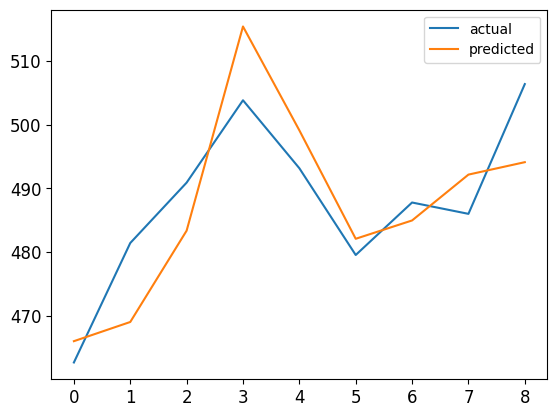

In [53]:
plt.plot(comparison['actual'], label = 'actual')
plt.plot(comparison['predicted'], label = 'predicted')

plt.legend()

plt.show()

# Conv1D

### Last Layer: GRU (you can change it to SimpleRNN or LSTM as well)

In [54]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid", input_shape=[9, 1]),
    keras.layers.GRU(32, activation='relu', return_sequences=True),
    keras.layers.GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])

In [55]:
np.random.seed(142)
tf.random.set_seed(142)

model.compile(loss="mse", optimizer='Adam')

history = model.fit(train_x, train_target, epochs=30)

Epoch 1/30
1/1 [==============================] - 4s 4s/step - loss: 1.3042
Epoch 2/30
1/1 [==============================] - 0s 99ms/step - loss: 1.2590
Epoch 3/30
1/1 [==============================] - 0s 54ms/step - loss: 1.2139
Epoch 4/30
1/1 [==============================] - 0s 58ms/step - loss: 1.1696
Epoch 5/30
1/1 [==============================] - 0s 14ms/step - loss: 1.1255
Epoch 6/30
1/1 [==============================] - 0s 15ms/step - loss: 1.0818
Epoch 7/30
1/1 [==============================] - 0s 18ms/step - loss: 1.0381
Epoch 8/30
1/1 [==============================] - 0s 12ms/step - loss: 0.9940
Epoch 9/30
1/1 [==============================] - 0s 16ms/step - loss: 0.9486
Epoch 10/30
1/1 [==============================] - 0s 16ms/step - loss: 0.9022
Epoch 11/30
1/1 [==============================] - 0s 13ms/step - loss: 0.8548
Epoch 12/30
1/1 [==============================] - 0s 11ms/step - loss: 0.8067
Epoch 13/30
1/1 [==============================] - 0s 12ms/step

### Predictions

In [56]:
#Predict:
y_pred = model.predict(test_x)

1/1 [==============================] - 0s 468ms/step


In [57]:
#Remember, these are standardized values. 

comparison = pd.DataFrame()

comparison['actual'] = scaler.inverse_transform([test_target]).flatten()
comparison['predicted'] = scaler.inverse_transform(y_pred).flatten()

In [58]:
rmse = mean_squared_error(comparison['actual'], comparison['predicted'])

In [59]:
performance = pd.concat([performance, pd.DataFrame({'model':"Conv 1D", 
                                                    'RMSE': [rmse]}, index=[0])])

In [60]:
performance.sort_values(by=['RMSE'],ascending=True)

,model,RMSE
0,GRU,65.980604
0,Simple RNN,69.480647
0,LSTM,93.094727
0,Conv 1D,182.937932


The RMSE score is the measure that denotes the root mean squared error which should be minium for the best fit model. Here we can see the the RMSE of **GRU is the lowest** , followed by Simple RNN , LSTM and Conv 1D. Based on the RMSE value we can say that **GRU is the BEST model** based on the given dataset.